In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE
from PIL import Image
import os
import glob
from keras import layers, Input
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.models import Sequential, Model
import keras_tuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

tf.__version__

ModuleNotFoundError: ignored

In [ ]:
# Before using the data need to upload on to drive
# This file will be deleted at the end of the session
# Go to file on left hand side of the screen then upload file (Can upload the file to root easier access)
# File extracted will be saved in content
from zipfile import ZipFile
file_name = '/trafficsigns_dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


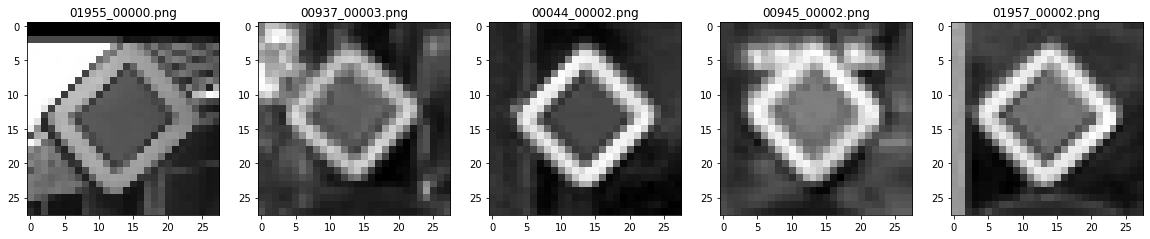

In [ ]:
# This is just to test if image is loaded correctly
import random

import matplotlib.image as mpimg

plt.figure(figsize=(20,20))
test_folder=r'/content/trafficsigns_dataset/diamond/rightofway'
for i in range(5):                                                    # Randomly loaded 5 images
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img, cmap = 'gray')

In [ ]:
# class DatasetReader:
#     def __init__(self, image_folder):
#         self.image_folder = image_folder
#         self.shapeImageFeatures = []                          # Features of the shape image
#         self.shapeClassName = []                              # Shape class name 
#         self.shapeClassNameEncoderDictionary = []             # Shape class name dictionary 
#         self.signImageFeatures = []                           # Features of the sign image
#         self.signClassName = []                               # Sign class name 
#         self.signClassNameEncoderDictionary = []              # Sign class name dictionary

#     def create_shape_dataset(self):
#         for dir1 in os.listdir(self.image_folder):
#             if not (dir1.startswith('.') or dir1.endswith('.txt')):
#                 for dir2 in os.listdir(os.path.join(self.image_folder, dir1)):            # Each of the directory has a sub directory
#                     if not (dir2.startswith('.') or dir2.endswith('.txt')):
#                         for file in os.listdir(os.path.join(self.image_folder, dir1, dir2)):
#                             if not file.startswith('.'):
#                                 image_path = os.path.join(self.image_folder, dir1, dir2, file)
#                                 image = keras.preprocessing.image.load_img(image_path)
#                                 image = keras.preprocessing.image.img_to_array(image)
#                                 image = image.astype('float32')
#                                 # image /= 28
#                                 self.shapeImageFeatures.append(image)
#                                 self.shapeClassName.append(dir1)
#                                 self.signImageFeatures.append(image)
#                                 self.signClassName.append(dir2)
    
#     def label_encoder(self):
#       self.shapeClassNameEncoderDictionary = {k: v for v, k in enumerate(np.unique(self.shapeClassName))}
#       self.signClassNameEncoderDictionary = {k: v for v, k in enumerate(np.unique(self.signClassName))}
#       self.shapeClassName = [self.shapeClassNameEncoderDictionary[self.shapeClassName[i]] for i in range(len(self.shapeClassName))]
#       self.signClassName = [self.signClassNameEncoderDictionary[self.signClassName[i]] for i in range(len(self.signClassName))]

    


In [ ]:
# imageDataReader = DatasetReader("/content/trafficsigns_dataset")
# imageDataReader.create_shape_dataset()
# imageDataReader.label_encoder()
# print(f"This is the number shape features: {len(imageDataReader.shapeImageFeatures)}")
# print(f"This is the number shape label: {len(imageDataReader.shapeClassName)}")
# print(f"This is the number sign features:  {len(imageDataReader.signClassName)}")
# print(f"This is the number sign label:  {len(imageDataReader.signClassName)}")

This is the number shape features: 3699
This is the number shape label: 3699
This is the number sign features:  3699
This is the number sign label:  3699


# **1. Data Preparation**
**Labeling data by its shape ans type**

Data will be stored in a dataframe which has image path, shape and type as columns

In [ ]:
image_list = []

for filepath in glob.glob('./trafficsigns_dataset/*/*/*.png', recursive=True):
    sign_shape = filepath.split('\\')[1]
    sign_type = filepath.split('\\')[2]
    image_list.append((filepath, sign_shape, sign_type ))
    
    
# create a dataframe
data = pd.DataFrame(data= image_list, columns=["image_path", 'sign_shape','sign_type'])
    

In [ ]:
# inspecting the dataframe
data.head()

In [ ]:
# data shape
data.shape

In [ ]:
print("numbers of shape:", len(data.sign_shape.unique()))
data.sign_shape.unique()

In [ ]:
print("numbers of type:", len(data.sign_type.unique()))
data.sign_type.unique()

**Labels encoding**

Using label encoder from sklearn to transform label into integer

In [ ]:
labelEncoder = LabelEncoder()
data.sign_shape = labelEncoder.fit_transform(data.sign_shape)
data.sign_type = labelEncoder.fit_transform(data.sign_type)

In [ ]:
# inspecting the changes
data.head()

**Distributions of shape and type**

In [ ]:
plt.figure(figsize=(9,9))
for i in range(1,3):
    plt.subplot(2,1,i)
    data.iloc[:, i].sort_values().astype(str).hist()
    txt = "distribution of " + data.columns[i]
    plt.title(txt)

**<u>Observation</u>:**

 * Data has multiple classes for shape and type of the traffic sign
 * Class imbalance problem in shape and type <br>
 * performance measure : F1, log_loss and average accuracy(micro-average)<br>

What is the realistic result for performance measure?

# **2. Model Development**
* Goal:
* Setup the experiment:
* Baseline Model:
* incremental changes:

In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## **2.1 Image Data Generator**

### **2.1.2 Shape**

Split data into train and validation set

In [ ]:
train, validation = train_test_split(data, random_state = 0, test_size=0.2)
print("Train data : {}\nVal Data: {}".format(train.shape[0], validation.shape[0]))

In [ ]:
train.loc[:,'sign_shape'] = train.loc[:,'sign_shape'].astype('str')
validation.loc[:, 'sign_shape'] = validation.loc[:,'sign_shape'].astype('str')

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 32

train_shape_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_shape_generator = val_datagen.flow_from_dataframe(
        dataframe=validation,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

### **2.1.2 Type**

In [ ]:
train, validation = train_test_split(data, random_state = 42, test_size=0.2)
print("Train data : {}\nVal Data: {}".format(train.shape[0], validation.shape[0]))

In [ ]:
train.loc[:,'sign_type'] = train.loc[:,'sign_type'].astype('str')
validation.loc[:, 'sign_type'] = validation.loc[:,'sign_type'].astype('str')

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 32

train_type_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_type_generator = val_datagen.flow_from_dataframe(
        dataframe=validation,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

## **2.2 Build Model**

### **2.2.1 Neutral Network**

Sequential API

In [ ]:
INPUT_DM = (28,28,3)
NUMBERS_OF_SHAPE = len(data.sign_shape.unique())
NUMBERS_OF_SIGN = len(data.sign_type.unique())

#### 2.2.1.1 Shape

#### A. Baseline Model

**Build Model**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,3)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(5)
])
model.summary()

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

**Train model**

In [ ]:
history = model.fit_generator(train_shape_generator, validation_data = validation_shape_generator, epochs=50, verbose=0)

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

#### A. Baseline Model

In [ ]:
def parameters( layer, units, activation, dropout, learningRate, numbers_of_label):
    model = keras.Sequential([tf.keras.layers.Flatten(input_shape=INPUT_DM)])
    # Tune the number of layers
    for i in range(layer):
        model.add(layers.Dense(units=units, activation=activation))
    # tune dropout  
    if dropout:
        model.add(layers.Dropout(rate=0.3))
    # output layer
    model.add(layers.Dense(numbers_of_label, activation='softmax'))
    # loss function $ learning rate
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learningRate),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])
    return model

# pass through arguments
def build_model(hp):
    layer = hp.Int("num_layers", 1, 3)
    units = hp.Int("units", min_value=16, max_value=512, step=15)
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu', 'sigmoid'])
    dropout = hp.Boolean('dropout')
    learningRate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    numbers_of_label=NUMBERS_OF_SHAPE
    model = parameters( layer=layer, units= units, activation=activation,dropout=dropout,
                      learningRate=learningRate, numbers_of_label=numbers_of_label)   
    return model


build_model(kt.HyperParameters())

Search for

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_categorical_accuracy",
    max_trials=4,
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_shape_generator, epochs=2, validation_data=validation_shape_generator)

In [ ]:
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

#### 2.2.1.1 Type

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/keras_tuner/

Hoang check links for documentation on tuner